This notebook deals with the tree-based methods used for builiding bitcoin price prediction models. 

The following tree-based methods are used:

1. Decision tree regressor
2. Random forest regressor
3. Gradient boosting regressor

The general way of method validation is shown below
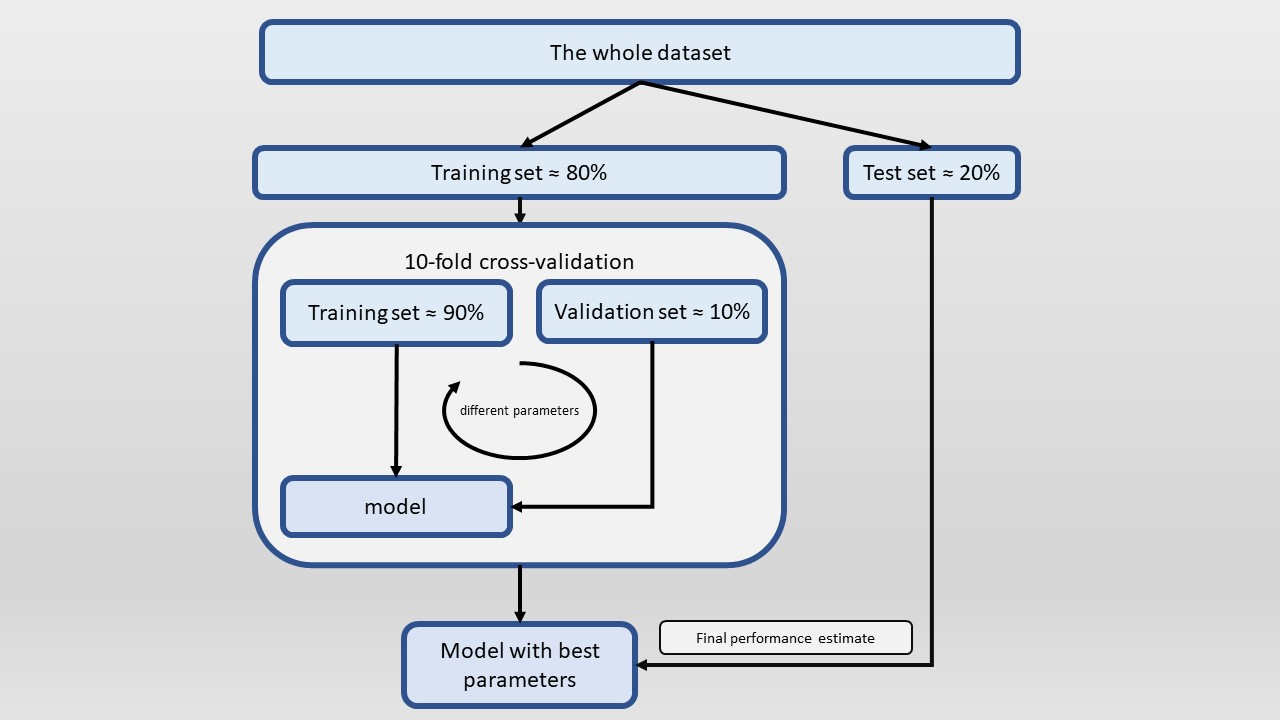

The main dataset is split into two sets: the training set and the test set. The best parameters for each method are sought by the cross-validation method. At the end each method is fitted on the whole training set and final evaluation is carried out on the test set. __Note:__  cross-validation is not necessary for random forest. 
Performance of a method is evaluated by calculating the root mean squared error (RMSE). All parameters are searched using the GridSearchCV method.

__Note:__ One feature was added to the dataset - google search trends for bitcoin (comparing to regression models)


In [144]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split,cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')

In [14]:
data=pd.read_csv('data_cleaning/BTC_data2.csv',index_col='Date')
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')

In [57]:
#function that uses GridSearchCV method for searching the best parameters
def search_params(*,model,X,y,parameters,cv=10):
    GScv=GridSearchCV(estimator=model,param_grid=parameters,scoring='neg_root_mean_squared_error',cv=cv)
    GScv.fit(X,y)
    return GScv.best_params_,-GScv.best_score_

In [64]:
#function for the final estimate 
def final_estimate(*,model,X_train,X_test,y_train,y_test,best_pars):
    model_temp=model(**best_pars)
    model_temp.fit(X_train,y_train)
    y_pred=model_temp.predict(X_test)
    return mean_squared_error(y_test,y_pred,squared=False)

Preparing _X_ and _y_ matrices

In [39]:
X=data.drop('BTC price [USD]',axis=1)
y=data['BTC price [USD]']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,shuffle=True)

### Regression tree

Parameters to be optimized: 
- maximum depth of tree
- minimum number of samples required to be at a leaf node

In [58]:
depths=np.arange(1,30,1)
min_leaf_number=np.arange(1,6)

DecisionTreePar=[{'max_depth':max_depth, 'min_samples_leaf':min_leaf_number}]

DT_best_par,DT_best_score=search_params(model=DecisionTreeRegressor(),X=X_train,y=y_train,parameters=DecisionTreePar)

print('Best score for decision tree: {}, best parameters: {}'.format(DT_best_score,DT_best_par))

Best score for decision tree: 529.4892054398562, best parameters: {'max_depth': 11, 'min_samples_leaf': 1}


### Random Forest Regression

Random forest regression does not need cross-validation, _cv_ number is set to two. Variables to be optimized: 
 - maximum depth of tree 
 - number of features to consider when looking for the best split. 
 - number of trees in the forest

__optimazing this tree may take a while...__

<br> _simulation results_ Best score for RandomForestRegression tree: 502.7960985213429, best parameters: {'max_depth': 18, 'max_features': 4, 'n_estimators': 200}

In [60]:
depths=np.arange(1,20,1)
max_features=np.arange(1,X.shape[1]+1,1)
max_tree=np.arange(200,1000,200)

RandomForestRegPar=[{'max_depth':depths, 'max_features':max_features,'n_estimators':max_tree}]

RFR_best_par,RFR_best_score=search_params(model=RandomForestRegressor(),X=X_train,y=y_train,parameters=RandomForestRegPar,cv=2)

print('Best score for RandomForestRegression tree: {}, best parameters: {}'.format(RFR_best_score,RFR_best_par))

Best score for RandomForestRegression tree: 502.7960985213429, best parameters: {'max_depth': 18, 'max_features': 4, 'n_estimators': 200}


### GradientBoostingRegressor
Parameters to be optimized: 
 - learning rate
 - maximum depth of tree
 - number of boosting stages
 
__optimazing this tree may take a while...__
<br> _simulation results_ Best score for GradientBoostingRegressor tree: 409.1974096575409, best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

In [61]:
depths=np.arange(1,15,1)
num_of_trees=np.array([50,100,200,300,500])
learning_rates=np.array([0.001,0.01,0.1,0.2])

GradientBoostingRegPar=[{'n_estimators':num_of_trees,
                       'max_depth':depths,
                       'learning_rate':learning_rates}]

GBR_best_par,GBR_best_score=search_params(model=GradientBoostingRegressor(),X=X_train,y=y_train,parameters=GradientBoostingRegPar,cv=10)

print('Best score for GradientBoostingRegressor tree: {}, best parameters: {}'.format(GBR_best_score,GBR_best_par))


Best score for GradientBoostingRegressor tree: 409.1974096575409, best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


#### Final evaluation 

In [185]:
import re

models=[DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor]
pars=[DT_best_par,RFR_best_par,GBR_best_par]

for m,p in zip(models,pars):
    name=re.findall("\w+'>",str(m))[0][:-2]
    score=final_estimate(model=m,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,best_pars=p)
    print('RMSE of the test set for {} = {}'.format(name,round(score,2)))


RMSE of the test set for DecisionTreeRegressor = 668.17
RMSE of the test set for RandomForestRegressor = 409.34
RMSE of the test set for GradientBoostingRegressor = 419.09


Comment: First of all the tree methods perfom much better than regression (RMSE for the best model using linear regression was equal to 2170). RandomForestRegressor obtained the best result and this method will be investigated further.

### Further investigation of RandomForestRegressor

Feature importances

In [96]:
model=RandomForestRegressor(**RFR_best_par)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

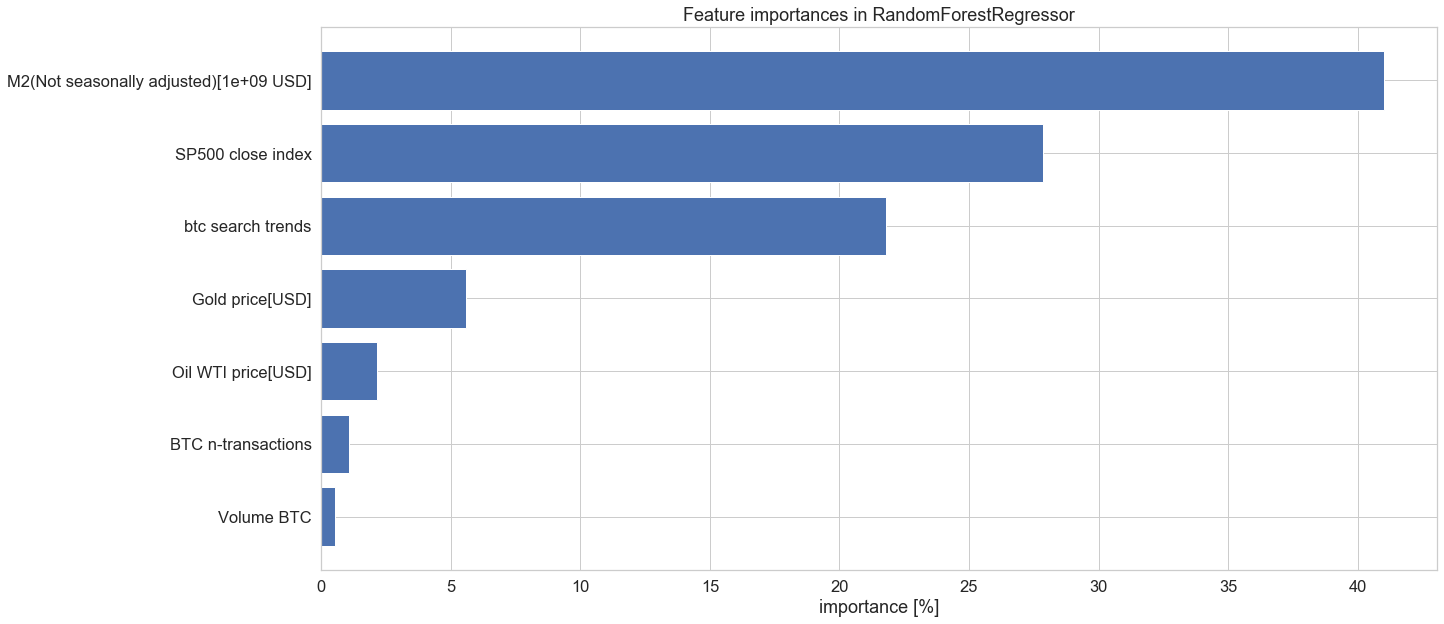

In [184]:
idx_sorted=model.feature_importances_.argsort()
plt.figure(figsize=(20,10))
plt.barh(X.columns[idx_sorted],width=model.feature_importances_[idx_sorted]*100)
plt.xlabel('importance [%]')
plt.title('Feature importances in RandomForestRegressor')
plt.show()

Accuracy of predictions

In [97]:
prediction=pd.DataFrame(data=np.hstack( (y_test.values.reshape(-1,1),y_pred.reshape(-1,1))),
             columns=['true price','predicted price'],
            index=y_test.index)
prediction.sort_index(inplace=True)
# analysis['difference absolute']=abs(analysis['true price']-analysis['predicted'])
# analysis['difference']=analysis['true price']-analysis['predicted']
prediction

,true price,predicted price
Date,,
2014-12-03,378.00,352.373521
2014-12-07,378.00,373.426500
2014-12-08,375.00,326.230421
2014-12-11,360.50,352.979950
2014-12-12,350.00,285.254500
...,...,...
2020-04-27,7789.77,7675.160925
2020-04-30,8624.28,8576.520442
2020-05-02,8985.58,8638.141130


The value of RMSE is not very meaningful because the whole time period was taken into account. For example in 2014 bitcoin price was about 400$. To have better insigh into the method accuracy the percentage mistake is calculated.

In [130]:
def percentage_discrete(x):
    x=abs(x)
    if x>0 and x<=10:
        return 1
    elif x>10 and x<=20:
        return 2
    elif x>20 and x<=30:
        return 3
    elif x>30 and x<=40:
        return 4
    elif x>40 and x<=50:
        return 5
    elif x>50 and x<=60:
        return 6
    elif x>60 and x<=70:
        return 7
    elif x>70 and x<=80:
        return 8
    elif x>80 and x<=90:
        return 9
    else: return 10

In [131]:
prediction['percentage error']=100*(prediction.iloc[:,0]-prediction.iloc[:,1])/prediction.iloc[:,0]
prediction['percentage error discrete']=prediction['percentage error'].apply(percentage_discrete)
prediction

,true price,predicted price,percentage error,percentage error discrete
Date,,,,
2014-12-03,378.00,352.373521,6.779492,1
2014-12-07,378.00,373.426500,1.209921,1
2014-12-08,375.00,326.230421,13.005221,2
2014-12-11,360.50,352.979950,2.086006,1
2014-12-12,350.00,285.254500,18.498714,2
...,...,...,...,...
2020-04-27,7789.77,7675.160925,1.471277,1
2020-04-30,8624.28,8576.520442,0.553780,1
2020-05-02,8985.58,8638.141130,3.866627,1


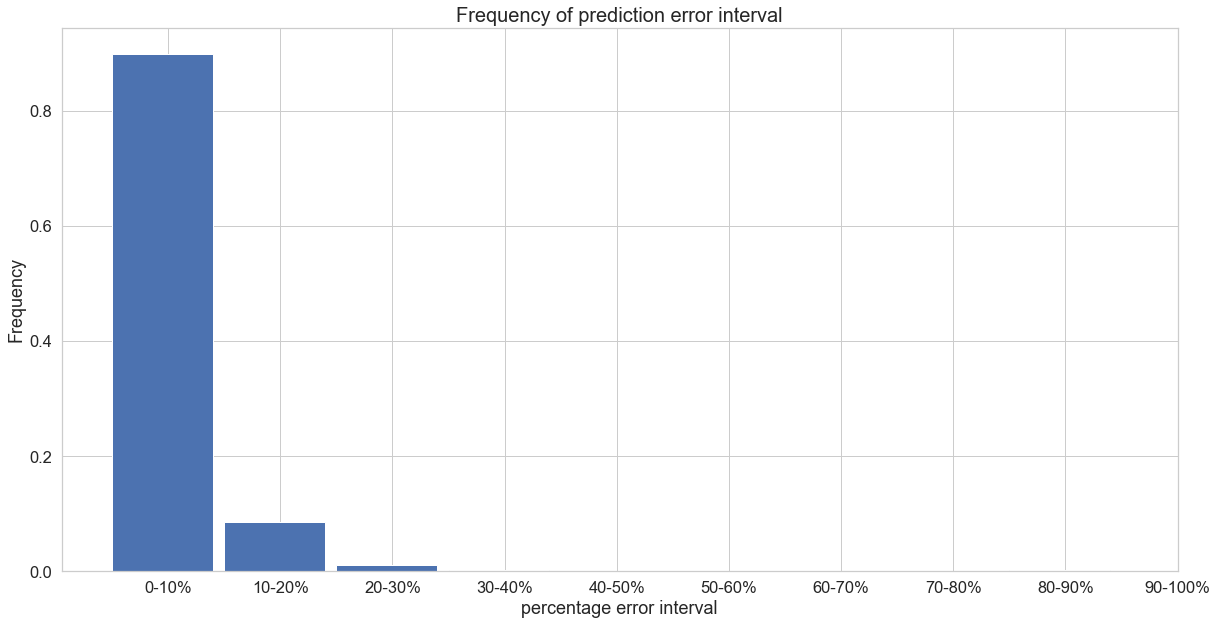

number of errors greater than 50% = 1 out of 396 predictions
the mean percentage error = 3.996577900256478


In [183]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

bins=np.arange(1,11,1)
prediction['percentage error discrete'].plot(kind='hist',bins=bins,width=0.9,align='left',density=True,figsize=(20,10))

labels=[str(i)+'-'+str(j)+'%' for i,j in zip(np.arange(0,100,10),np.arange(10,110,10))]

plt.xticks(np.arange(1,11,1),labels=labels)
plt.xlabel('percentage error interval')
plt.ylabel('Frequency')
plt.title('Frequency of prediction error interval',fontsize=20)
plt.show()

greater50=np.unique(np.where(abs(prediction['percentage error'].values)>=50,1,0),return_counts=True)[1][1]

print('number of errors greater than 50% = {} out of {} predictions'.format(greater50,X_test.shape[0]))
print('the mean percentage error = {}'.format(prediction['percentage error'].abs().mean()))

The model is wrong by 4% on average! Over 85% of the error lies in the 0-10% interval. It means that 85% of the predictions out of 396 is less than 10%. __Reminder:__ The testset was not involved in selecting the best parameters! <br>
Below is a figure showing the accuracy of the model

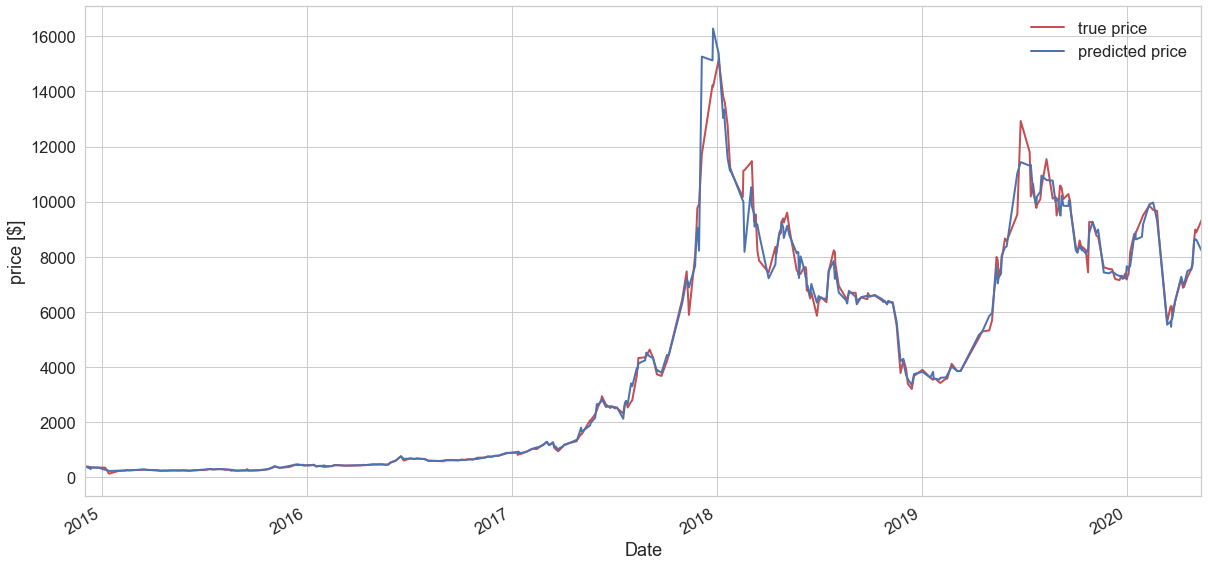

In [180]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
prediction[['true price','predicted price']].plot(kind='line',color=['r','b'],figsize=(20,10),lw=2)
plt.ylabel('price [$]')
plt.show()

### Summary and the conclusion

1. The tree-based methods predict bitcoin price much better than the linear regression model (__Note__: in the linear regression model google trends was not involved, this may be a relevant factor, its importance is over 20% in random forest tree, nevertheless it is rather impossible that adding this factor would result in decreasing RMSE by 80%)
2. Built models showed that the tree-based methods are a great starting point for building price prediction model. It must be emphasized that in practice the model built in this notebook is useless - to predict bitcoin price all used variables need to be known. While the values like M2 money supply or google trends don't change rapidly the other values change more dynamically. Not to mention that bitcoin volume and number of transaction are known at the end of a day.